In [1]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cp

## Problem 4 (`cvxpy`)

In this problem we will explore the basics of `cvxpy`, a Python package for solving convex optimization problems. `cvxpy` has a good tutorial [here](https://www.cvxpy.org/tutorial/intro/index.html), so read that page before proceeding with this problem (the section on "parameters", while useful, is not important for this homework, so consider that section optional for now).

Consider a vector variable $x = [x_1,  x_2,  x_3]^T$. Use `cvxpy` to compute the minimizer of the following objective function
$$
x_1^2 + 2x_2^2 + 3.5x_3^2,
$$

subject to the constraint

$$
\begin{bmatrix}
0.707 & 0.707 & 0 \\
-1 & 0 & 0 \\
0 & -1 & 0 \\
0 & 0 & -1
\end{bmatrix}x \le \begin{bmatrix}
2 \\
-1 \\
-1 \\
-3
\end{bmatrix}.
$$

Print the optimal $x$ and the optimal value of the objective function.

Notice how much easier it is to use `cvxpy` than to write our own optimization algorithm from scratch!

In [2]:
# Define the optimization variable
# Create Vector Variable with shape (3,)
x = cp.Variable(3)

# Now define the given quadratic objective function
# Form objective (minimize the objective function: x1^2 + 2*x2^2 + 3.5*x3^2)
objective = cp.Minimize(cp.square(x[0]) + 2 * cp.square(x[1]) + 3.5 * cp.square(x[2]))

# Define the constraint matrix (A)
A = np.array([[0.707, 0.707, 0],
              [-1, 0, 0],
              [0, -1, 0],
              [0, 0, -1]])

# Define the RHS vector (b) which corresponds to the right-hand side of each inequality constraint
b = np.array([2, -1, -1, -3])

# Define the constraints (A @ x <= b)
constraints = [A @ x <= b]

# Construct the problem
prob = cp.Problem(objective, constraints)

# Solve the problem
optimal_value = prob.solve()

# Output Results
print("Status:", prob.status) # 'Optimal' means the problem was solved successfully
print("Optimal objective function value:", optimal_value) # min value of the objective over all choices of x that satisfy the constraints
print("Optimal variable value (x):", x.value) # values of x that achieve the optimal objective

Status: optimal
Optimal objective function value: 34.5
Optimal variable value (x): [1. 1. 3.]


## Problem 5 (Control Barrier Function and CBF-QP)

In this problem, using the concepts and code you have developed in the previous problems, you will implement a CBF-QP safety filter.
We will restrict ourselves to a simple 1D system so that you can verify your results analytically if needed, but note that the theory extends to higher dimensional problems, and try to keep your code general so that it could still work on a different system and choice of CBF.

Consider the following 1D single integator dynamics $ \dot{x} = u $ and let $b(x) = x^2 - 1$.


### (a) Computing the Lie derivative
What is the expression for $\nabla b(x)^T f(x,u)$?

- Gradient of \(b(x)\):
$$
$\nabla b(x) = \frac{d}{dx}(x^2 - 1) = 2x$
$$    

- Dynamics:

$$
$f(x,u) = u$          
$$

- Now, Lie derivative $ \nabla b(x)^T f(x, u) $ is:

$$
$\nabla b(x)^Tf(x,u) = (2x) \cdot u = 2xu$ 
$$

In [3]:
# The Lie derivative can also be computed using the script below:

import sympy as sp
# Define symbolic variables
x, u = sp.symbols('x u')

# Define the barrier function and dynamics
b = x**2 - 1
f = u  # since dx/dt = u

# Compute gradient of b(x)
grad_b = sp.diff(b, x)

# Compute Lie derivative: grad_b * f
lie_derivative = grad_b * f

# Display results
print("b(x) =", b)
print("∇b(x) =", grad_b)
print("f(x,u) =", f)
print("Lie derivative ∇b(x)^T f(x,u) =", lie_derivative)

b(x) = x**2 - 1
∇b(x) = 2*x
f(x,u) = u
Lie derivative ∇b(x)^T f(x,u) = 2*u*x


### (b) Solving the CBF-QP
Suppose that your desired control is $u_\mathrm{des}=0.5$, which is to move in the positive $x$-direction at constant velocity. But the safety filter enforces that $x^2 \geq 1$, i.e., keep a 1 unit away from the origin.

The CBF safety filter essentially chooses a control input that is as close to $u_\mathrm{des}$ as possible while satisfying the CBF inequality constraint.

$$
u_\mathrm{safe}(x) = \underset{u}{\text{argmin}} \| u - u_\mathrm{des}\|_2^2 \:\: \text{subj. to} \:\: \nabla b(x)^Tf(x,u) \geq -\alpha(b(x))
$$

This is referred to as the CBF-QP since it is a quadratic program (quadratic objective and linear constraints). For simplicity, we assume there are no other constraints on controls.

Let $\alpha(z) = az$, $a=0.5$
Use `cvxpy` to solve the CBF-QP for $x=-3$, $x=-2$ and $x=-1.1$.

Report the corresponding safe control values.

Hint: You may find the `Parameter` variable in `cvxpy` helpful. It allows you to update certain parameters without needing to reconstruct the optimization each time.


In [4]:
# Constants
u_des = 0.5 # Desired control input
a = 0.5 # We're given that alpha(z) = a * z

# List of state values to compute the safe control
x_vals = [-3, -2, -1.1]

# In the loop, we,
# Step 1: Define the optimization variable
# Step 2: Define the safety constraint using the Control Barrier Function (CBF)
# Step 3: Define the objective function

for x_val in x_vals:
    
    # Rebuild the optimization variable and the QP for each x
    u = cp.Variable(name='u')
    
    # The CBF constraint is: 2*x*u >= -0.5*(x^2 - 1) 
    constraint = [2 * x_val * u >= -a * (x_val**2 - 1)]
    
    # Objective: minimize the deviation from the desired control
    objective = cp.Minimize((u - u_des)**2)
    
    # solve the problem
    prob = cp.Problem(objective, constraint)
    prob.solve()
    
    print(f"For x = {x_val:.1f}:")
    print(f"    Status:", prob.status)
    print(f"    Safe control u = {u.value:.4f}")
    print(f"    Optimal value = {prob.value}")
    print()

For x = -3.0:
    Status: optimal
    Safe control u = 0.5000
    Optimal value = 1.232595164407831e-32

For x = -2.0:
    Status: optimal
    Safe control u = 0.3750
    Optimal value = 0.015625

For x = -1.1:
    Status: optimal
    Safe control u = 0.0477
    Optimal value = 0.20455061983471068



### (c) Applying the CBF safety filter
Now, simulate the system starting from $x=-5$ and with $u_\mathrm{des}=0.5$, but the CBF safety filter is applied. Plot the state and control sequence for $a=2$, $a=1$, $a=0.5$ and $a=0.1$ where $\alpha(z) = az$. 
Comment on how the trajectory changes as $a$ changes. What is your interpretation of $a$?

Use $\Delta t = 0.05$ and simulate for 500 steps.

Note that the CBF theory is for continuous-time dynamics, but when we simulate, we use discrete-time dynamics. There are some practical issues that we need to be careful about (see [this paper](https://arxiv.org/abs/2404.12329) for more details), but right now, let's stick to using a reasonably small time step.

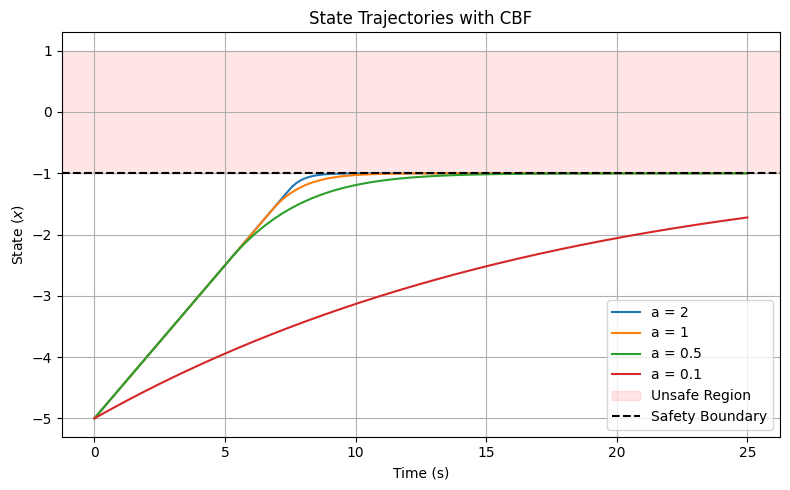

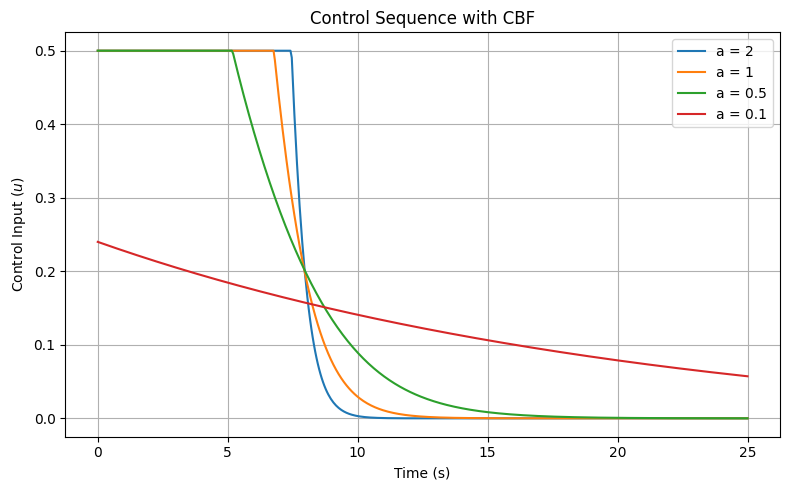

In [5]:
# Construct discrete-time dynamics for numerical simulation (using Euler method)
# discretize the continuous dynamics for each simulation step

# Returns a control input u that is as close as possible to u_des while
# satisfying the safety constraint defined by the Control Barrier Function.

def compute_safe_control(x_val, a, u_des):
    # Optimization variable for control input
    u = cp.Variable(name='u')

    # Define CBF constraint  (derived from Lie derivative condition)
    constraint = [2 * x_val * u >= -a * (x_val**2 - 1)]

    # Objective function: minimize the deviation from desired control u_des
    objective = cp.Minimize((u - u_des)**2)

    # Solve the quadratic program (CBF-QP) and return safe control input
    prob = cp.Problem(objective, constraint)
    prob.solve()
    return u.value


# Simulate the system dynamics applying CBF-QP safety filter at each step

# Reurns the state trajectory over time (x_vals) and 
# the corresponding control inputs applied at each step (u_vals)

def simulate_system(a, u_des=0.5, x0=-5, dt=0.05, steps=500):
    
    # Initialize arrays to store state and control trajectories
    x_vals = np.zeros(steps + 1) # state
    u_vals = np.zeros(steps) # control

    # Set initial condition
    x_vals[0] = x0

    # Simulation loop: compute safe control and update state iteratively
    for i in range(steps):
        
        # Compute the safe control for current state using CBF-QP
        u_safe = compute_safe_control(x_vals[i], a, u_des)
        u_vals[i] = u_safe

        # Discrete-time update of the state
        x_vals[i + 1] = x_vals[i] + dt * u_safe

    return x_vals, u_vals


# Simulation parameters

dt = 0.05 # Time step
steps = 500 # Number of simulation steps
u_des = 0.5 # Desired control input
x0 = -5 # Initial condition

# Different values of a to simulate 
a_values = [2, 1, 0.5, 0.1]
sim_results = {}

# Run simulation for each a value
for a in a_values:
    sim_results[a] = simulate_system(a, u_des, x0, dt, steps)

# Time vectors for plotting
t_state = np.linspace(0, dt*steps, steps+1)
t_control = np.linspace(0, dt*steps, steps)  


# Plot the state trajectories 
plt.figure(figsize=(8, 5))
for a in a_values:
    x_vals, _ = sim_results[a]
    plt.plot(t_state, x_vals, label=f'a = {a}')
plt.axhspan(-1, 1, color='red', alpha=0.1, label='Unsafe Region')
plt.axhline(y=-1, color='k', linestyle='--', label='Safety Boundary')
plt.xlabel('Time (s)')
plt.ylabel('State ($x$)')
plt.title('State Trajectories with CBF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the control Sequence
plt.figure(figsize=(8, 5))
for a in a_values:
    _, u_vals = sim_results[a]
    plt.plot(t_control, u_vals, label=f'a = {a}')
plt.xlabel('Time (s)')
plt.ylabel('Control Input ($u$)')
plt.title('Control Sequence with CBF')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Comment on how the trajectory changes as $a$ changes. What is your interpretation of $a$?

Looking at the trajectory plot, we can see that with the smallest $a$ value of 0.1, the system never actually reaches the safe boundary within the 500 simulation steps. At $a$ = 0.5, we can see that the system hits the safety boundary in about 15 seconds. From there, increasing $a$ to 1 and then to 2 results in only marginal improvements in convergence time, suggesting that small increases in $a$ can yield large performance gains, but there's diminishing return beyond a certain point. Observing the control input plot, we can see that for larger alpha values, the controller holds at 0.5 until the last moment, then plunges almost vertically to enforce safety, wehereas for smaller alpha values, the control input gradually decays. 

We can interpret $a$ as the parameter that regulates how gently or aggressively the barrier constraint is enforced, influencing the system’s responsiveness in approaching the boundary. 

A larger $a$ is seen to be more aggressive, we mnaintain the desired control $( u_{\text{des}} = 0.5 )$ until nearly reaching the safety boundary, and then the suddenly, the control sequence drops sharply to avoid the unsafe region. 

A smaller $a$ is seen to be more conservative. We dont reach the safety boundary as quickly and sacrifice performance earlier on so that the approach to the safety boundary is more smooth and gradual. 

For applications, we need to consider the trade-off's between smaller and larger alpha values depending on how long we want to maintain the desired control and reach a boundary, or if we want a more gradual and robust approach, but at a slower rate. The following papers go into the practical applications and consideration of alpha for specific systems: [here](https://www.mdpi.com/2079-9292/11/22/3657) and [here](https://arxiv.org/abs/2201.01347)
